# Features engineer

In [ ]:
import os
import json
import random
import pickle
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔒 Global seed set to {SEED} | Using device: {device}")

# ============================================================
#                  EXPERIMENT CONFIGURATION
# ============================================================
EXPERIMENT_DIR = "../results/pytorch_MLP/model_setting/v1_X2X1_Tahn"
TRAIN_PATH = "../preprocessed_data/CAGE-merged/4. features selection/X2_all_rank_features_pruned_qn.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/4. features selection/X1_all_rank_features_pruned_qn.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
LOG_PATH = os.path.join(EXPERIMENT_DIR, "log.txt")
with open(LOG_PATH, "w") as f:
    f.write("")

def log(msg):
    print(msg)
    with open(LOG_PATH, "a") as f:
        f.write(f"{msg}\n")

log(f"🚀 PyTorch MLP Regression experiment started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")
feature_cols = [c for c in df_train_full.columns if c not in META_COLS]
log(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  K-FOLD DEFINITION
# ============================================================
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]
for i, fset in enumerate(folds):
    log(f"Fold {i+1}: {fset}")

# ============================================================
#                  MODEL DEFINITION
# ============================================================
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )



    def forward(self, x):
        return self.net(x)

# ============================================================
#                  TRAINING LOOP
# ============================================================
BATCH_SIZE = 128
EPOCHS = 1000
PATIENCE = 50
LR = 1e-3

results = []
preds_all = []

scaler = StandardScaler()

for fold_idx, val_chrs in enumerate(folds):
    log(f"\n🚀 Fold {fold_idx+1}/{len(folds)} | Val chromosomes: {val_chrs}")
    fold_dir = os.path.join(EXPERIMENT_DIR, f"fold_{fold_idx+1}")
    os.makedirs(fold_dir, exist_ok=True)

    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()
    df_val = df_val.reset_index().rename(columns={"index": "orig_idx"})

    X_train = scaler.fit_transform(df_train[feature_cols].values)
    X_val   = scaler.transform(df_val[feature_cols].values)
    y_train = df_train[TARGET_COL].values
    y_val   = df_val[TARGET_COL].values

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)),
                              batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                          torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)),
                            batch_size=BATCH_SIZE, shuffle=False)

    model = MLP(len(feature_cols)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # === validation ===
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss = criterion(preds, yb)
                val_losses.append(val_loss.item())

        val_loss_mean = np.mean(val_losses)
        train_loss_mean = np.mean(train_losses)

        if val_loss_mean < best_val_loss:
            best_val_loss = val_loss_mean
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(fold_dir, "best_model.pt"))
        else:
            patience_counter += 1

        if epoch % 50 == 0:
            log(f"Epoch {epoch:04d} | Train={train_loss_mean:.5f}, Val={val_loss_mean:.5f}")

        if patience_counter >= PATIENCE:
            log(f"⏸️ Early stopping at epoch {epoch}")
            break

    # ============================================================
    #                  EVALUATION
    # ============================================================
    model.load_state_dict(torch.load(os.path.join(fold_dir, "best_model.pt")))
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy().flatten()

    df_val["predicted_gex_rank"] = y_pred
    df_val["fold_id"] = fold_idx + 1
    preds_all.append(df_val[["orig_idx", "gene_name", "predicted_gex_rank", "fold_id"]])

    rho = spearmanr(y_val, y_pred)[0]
    log(f"📈 Fold {fold_idx+1} Overall Spearman ρ = {rho:.4f}")

    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        chr_rho = spearmanr(subdf["gex_rank"], subdf["predicted_gex_rank"])[0]
        chr_corrs.append({"chr": chrom, "spearman": chr_rho})
        log(f"   {chrom:<6s}: ρ = {chr_rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": rho,
        "per_chr": chr_corrs
    })

# ============================================================
#                  SAVE FINAL RESULTS
# ============================================================
df_preds_all = pd.concat(preds_all, ignore_index=True)
df_preds_all = df_preds_all.sort_values("orig_idx").reset_index(drop=True)

df_preds_all[["gene_name", "predicted_gex_rank"]].to_csv(
    os.path.join(EXPERIMENT_DIR, "predict_val.tsv"), sep="\t", index=False
)
log("💾 Final predictions saved (predict_val.tsv)")

mean_spearman = np.mean([r["overall_spearman"] for r in results])
log(f"🌍 Mean Spearman across folds = {mean_spearman:.4f}")
log(f"\n✅ PyTorch MLP Regression experiment finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


🔒 Global seed set to 42 | Using device: cuda
🚀 PyTorch MLP Regression experiment started at 2025-10-14 13:30:28
Feature count: 277
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1/5 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Epoch 0000 | Train=0.04735, Val=0.07329
Epoch 0050 | Train=0.01112, Val=0.06800
⏸️ Early stopping at epoch 61
📈 Fold 1 Overall Spearman ρ = 0.6172
   chr12 : ρ = 0.6381
   chr17 : ρ = 0.5923
   chr2  : ρ = 0.6171
   chr22 : ρ = 0.6278
   chr7  : ρ = 0.6257

🚀 Fold 2/5 | Val chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Epoch 0000 | Train=0.04739, Val=0.06247
Epoch 0050 | Train=0.01211, Val=0.06638
⏸️ Early stopping at epoch 56
📈 Fold 2 Overall Spearman ρ = 0.6503
   chr13 : ρ = 0.6145
   chr18 : ρ = 0.6333
   chr3  : ρ = 0.6484
   chr8  : ρ = 0.6707

🚀 Fold 3/

RuntimeError: File ../results/pytorch_MLP/model_setting/v1_X2X1_Tahn_n\fold_4\best_model.pt cannot be opened.

In [4]:
import os
import json
import random
import pickle
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# ============================================================
#                  GLOBAL REPRODUCIBILITY
# ============================================================
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔒 Global seed set to {SEED} | Using device: {device}")

# ============================================================
#                  EXPERIMENT CONFIGURATION
# ============================================================
EXPERIMENT_DIR = "../results/pytorch_FTTransformer/model_setting/v1_X2X1"
TRAIN_PATH = "../preprocessed_data/CAGE-merged/4. features selection/X2_all_rank_features_pruned_qn.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/4. features selection/X1_all_rank_features_pruned_qn.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
LOG_PATH = os.path.join(EXPERIMENT_DIR, "log.txt")
with open(LOG_PATH, "w") as f:
    f.write("")

def log(msg):
    print(msg)
    with open(LOG_PATH, "a") as f:
        f.write(f"{msg}\n")

log(f"🚀 FT-Transformer Regression experiment started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================
#                  DATA LOADING
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")
feature_cols = [c for c in df_train_full.columns if c not in META_COLS]
log(f"Feature count: {len(feature_cols)}")

# ============================================================
#                  K-FOLD DEFINITION
# ============================================================
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]
for i, fset in enumerate(folds):
    log(f"Fold {i+1}: {fset}")

# ============================================================
#                  FT-TRANSFORMER MODULES
# ============================================================
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x) + x

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Sequential(nn.Linear(dim, dim), nn.Dropout(dropout))

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(B, N, self.heads, D // self.heads).transpose(1, 2), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = dots.softmax(dim=-1)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(B, N, D)
        return self.to_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.1, ff_hidden_mult=4):
        super().__init__()
        self.attn = Residual(nn.Sequential(
            nn.LayerNorm(dim),
            Attention(dim, heads=heads, dropout=dropout)
        ))
        self.ff = Residual(nn.Sequential(
            nn.LayerNorm(dim),
            FeedForward(dim, hidden_dim=int(dim * ff_hidden_mult), dropout=dropout)
        ))

    def forward(self, x):
        x = self.attn(x)
        x = self.ff(x)
        return x

class FTTransformer(nn.Module):
    def __init__(self, num_features, dim=128, depth=3, heads=8, dropout=0.1):
        super().__init__()
        self.feature_embed = nn.Linear(1, dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
        self.transformer = nn.Sequential(*[
            TransformerBlock(dim, heads=heads, dropout=dropout) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, 1)

    def forward(self, x):
        # x shape: [B, F]
        x = x.unsqueeze(-1)                      # [B, F, 1]
        x = self.feature_embed(x)                # [B, F, dim]
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)  # [B, 1, dim]
        x = torch.cat((cls_tokens, x), dim=1)    # [B, F+1, dim]
        x = self.transformer(x)
        x = self.norm(x[:, 0])                   # [B, dim]
        return self.head(x)

# ============================================================
#                  TRAINING LOOP
# ============================================================
BATCH_SIZE = 128
EPOCHS = 1000
PATIENCE = 50
LR = 1e-3

results = []
preds_all = []

scaler = StandardScaler()

for fold_idx, val_chrs in enumerate(folds):
    log(f"\n🚀 Fold {fold_idx+1}/{len(folds)} | Val chromosomes: {val_chrs}")
    fold_dir = os.path.join(EXPERIMENT_DIR, f"fold_{fold_idx+1}")
    os.makedirs(fold_dir, exist_ok=True)

    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
    df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()
    df_val = df_val.reset_index().rename(columns={"index": "orig_idx"})

    X_train = scaler.fit_transform(df_train[feature_cols].values)
    X_val   = scaler.transform(df_val[feature_cols].values)
    y_train = df_train[TARGET_COL].values
    y_val   = df_val[TARGET_COL].values

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)),
                              batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                          torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)),
                            batch_size=BATCH_SIZE, shuffle=False)

    model = FTTransformer(num_features=len(feature_cols), dim=128, depth=3, heads=8, dropout=0.1).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
    criterion = nn.MSELoss()

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # === validation ===
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss = criterion(preds, yb)
                val_losses.append(val_loss.item())

        val_loss_mean = np.mean(val_losses)
        train_loss_mean = np.mean(train_losses)

        if val_loss_mean < best_val_loss:
            best_val_loss = val_loss_mean
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(fold_dir, "best_model.pt"))
        else:
            patience_counter += 1

        if epoch % 50 == 0:
            log(f"Epoch {epoch:04d} | Train={train_loss_mean:.5f}, Val={val_loss_mean:.5f}")

        if patience_counter >= PATIENCE:
            log(f"⏸️ Early stopping at epoch {epoch}")
            break

    # ============================================================
    #                  EVALUATION
    # ============================================================
    model.load_state_dict(torch.load(os.path.join(fold_dir, "best_model.pt")))
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy().flatten()

    df_val["predicted_gex_rank"] = y_pred
    df_val["fold_id"] = fold_idx + 1
    preds_all.append(df_val[["orig_idx", "gene_name", "predicted_gex_rank", "fold_id"]])

    rho = spearmanr(y_val, y_pred)[0]
    log(f"📈 Fold {fold_idx+1} Overall Spearman ρ = {rho:.4f}")

    chr_corrs = []
    for chrom, subdf in df_val.groupby("chr"):
        if len(subdf) < 2:
            continue
        chr_rho = spearmanr(subdf["gex_rank"], subdf["predicted_gex_rank"])[0]
        chr_corrs.append({"chr": chrom, "spearman": chr_rho})
        log(f"   {chrom:<6s}: ρ = {chr_rho:.4f}")

    results.append({
        "fold": fold_idx + 1,
        "val_chr": val_chrs,
        "overall_spearman": rho,
        "per_chr": chr_corrs
    })

# ============================================================
#                  SAVE FINAL RESULTS
# ============================================================
df_preds_all = pd.concat(preds_all, ignore_index=True)
df_preds_all = df_preds_all.sort_values("orig_idx").reset_index(drop=True)

df_preds_all[["gene_name", "predicted_gex_rank"]].to_csv(
    os.path.join(EXPERIMENT_DIR, "predict_val.tsv"), sep="\t", index=False
)
log("💾 Final predictions saved (predict_val.tsv)")

mean_spearman = np.mean([r["overall_spearman"] for r in results])
log(f"🌍 Mean Spearman across folds = {mean_spearman:.4f}")
log(f"\n✅ FT-Transformer Regression experiment finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


🔒 Global seed set to 42 | Using device: cuda
🚀 FT-Transformer Regression experiment started at 2025-10-14 14:04:48
Feature count: 277
Fold 1: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Fold 2: ['chr3', 'chr8', 'chr13', 'chr18']
Fold 3: ['chr4', 'chr9', 'chr14', 'chr19']
Fold 4: ['chr5', 'chr10', 'chr15', 'chr20']
Fold 5: ['chr6', 'chr11', 'chr16', 'chr21']

🚀 Fold 1/5 | Val chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
Epoch 0000 | Train=0.38701, Val=0.06646
Epoch 0050 | Train=0.04903, Val=0.03833
Epoch 0100 | Train=0.04638, Val=0.03758
⏸️ Early stopping at epoch 127
📈 Fold 1 Overall Spearman ρ = 0.6527
   chr12 : ρ = 0.6593
   chr17 : ρ = 0.6271
   chr2  : ρ = 0.6461
   chr22 : ρ = 0.6752
   chr7  : ρ = 0.6735

🚀 Fold 2/5 | Val chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
Epoch 0000 | Train=0.26929, Val=0.06417
Epoch 0050 | Train=0.04764, Val=0.03593


KeyboardInterrupt: 

🔥 Injected 50 extreme genes into X2


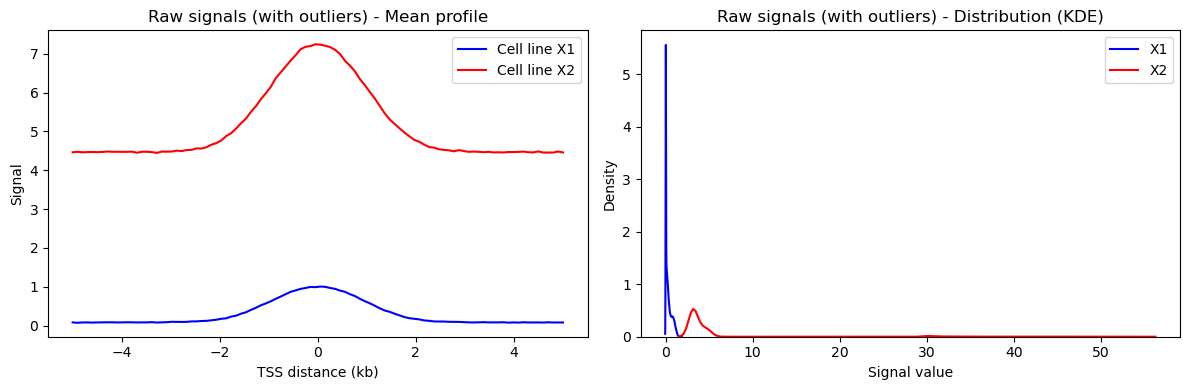

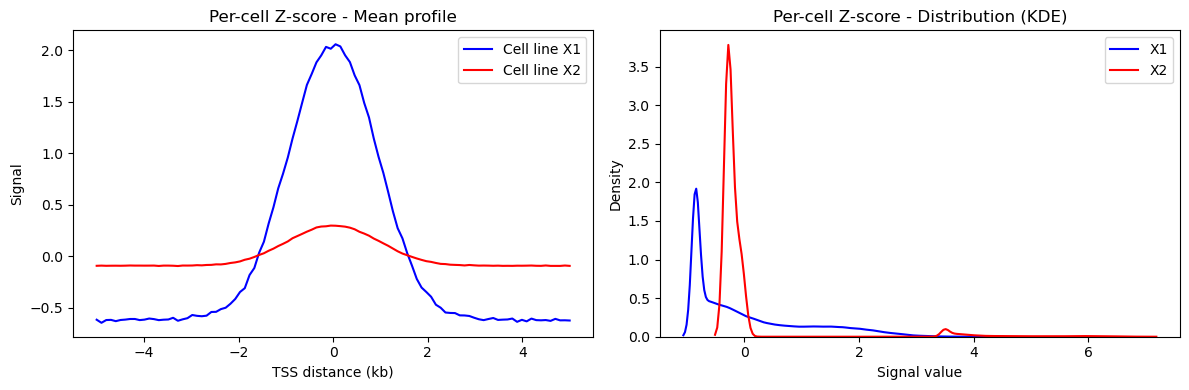

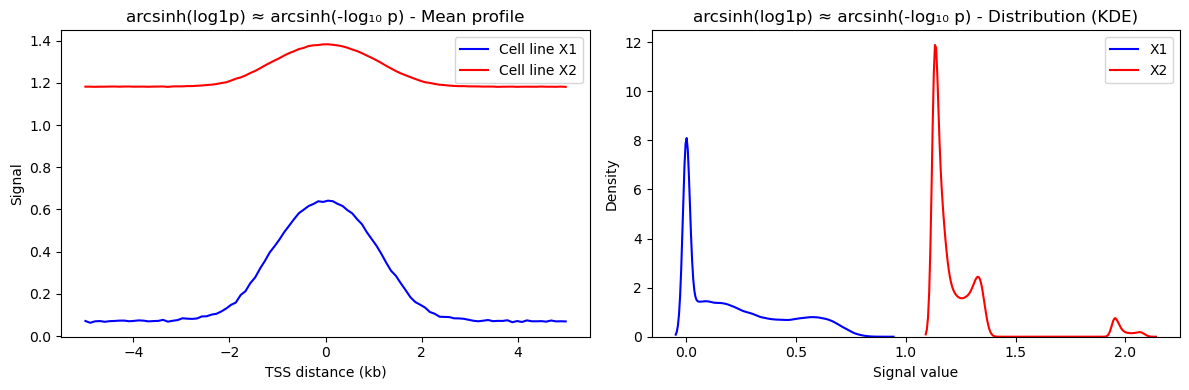

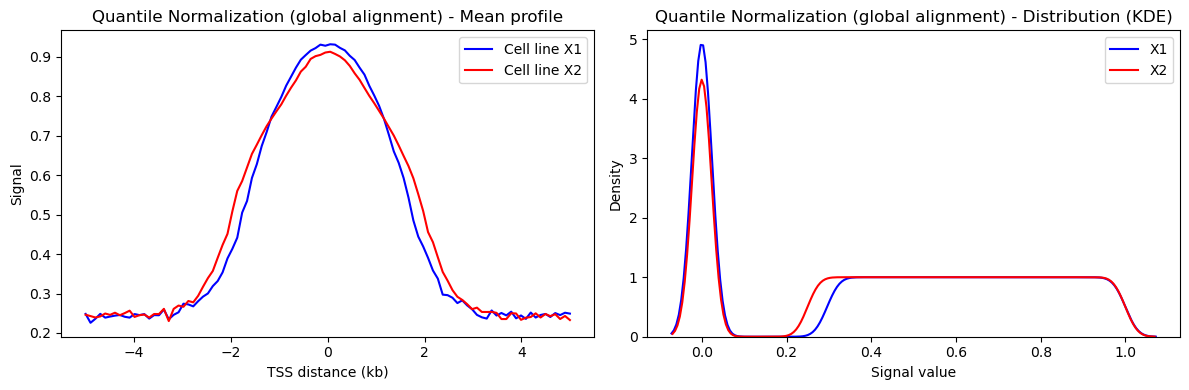

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import quantile_transform

np.random.seed(42)

# ------------------------------------------------------------
# 模擬兩個 cell line 的 signal 分佈
# ------------------------------------------------------------
n_genes = 1000
n_bins = 100  # 每個 gene 的 profile
x = np.linspace(-5, 5, n_bins)

def simulate_signal(n_genes, height=1.0, noise=0.2):
    """模擬 TSS 附近有 Gaussian-like peak 的 ChIP-seq signal"""
    peak = np.exp(-x**2 / 2) * height
    signals = peak + np.random.normal(0, noise, (n_genes, n_bins))
    signals = np.clip(signals, 0, None)
    return signals

# === Cell line X1: baseline
X1 = simulate_signal(n_genes, height=1.0)

# === Cell line X2: 整體偏高 + 加入極端 outlier 區域 ===
X2 = simulate_signal(n_genes, height=2.0) + 3
outlier_genes = int(n_genes * 0.05)
X2[-outlier_genes:, :] *= 10  # top 5% genes 有極高峰值

print(f"🔥 Injected {outlier_genes} extreme genes into X2")

# ------------------------------------------------------------
# 定義轉換方法
# ------------------------------------------------------------
def zscore_per_cell(X):
    mean = X.mean()
    std = X.std()
    return (X - mean) / std

def arcsinh_logp_like(X):
    """模擬 arcsinh(-log₁₀ p)：壓縮高值"""
    return np.arcsinh(np.log1p(X))

def quantile_norm(X1, X2):
    """讓 X1、X2 的分佈對齊（Quantile normalization）"""
    X_all = np.vstack([X1.flatten(), X2.flatten()]).T
    X_all_qn = quantile_transform(X_all, n_quantiles=100000, copy=True)
    X1_qn = X_all_qn[:, 0].reshape(X1.shape)
    X2_qn = X_all_qn[:, 1].reshape(X2.shape)
    return X1_qn, X2_qn

# ------------------------------------------------------------
# 應用轉換
# ------------------------------------------------------------
X1_raw, X2_raw = X1, X2
X1_z, X2_z = zscore_per_cell(X1), zscore_per_cell(X2)
X1_arc, X2_arc = arcsinh_logp_like(X1), arcsinh_logp_like(X2)
X1_qn, X2_qn = quantile_norm(X1, X2)

# ------------------------------------------------------------
# 視覺化函式
# ------------------------------------------------------------
def plot_comparison(X1, X2, title):
    plt.figure(figsize=(12, 4))

    # 平均 profile
    plt.subplot(1, 2, 1)
    plt.title(f"{title} - Mean profile")
    plt.plot(x, X1.mean(axis=0), label="Cell line X1", color="blue")
    plt.plot(x, X2.mean(axis=0), label="Cell line X2", color="red")
    plt.xlabel("TSS distance (kb)")
    plt.ylabel("Signal")
    plt.legend()

    # 分佈 KDE
    plt.subplot(1, 2, 2)
    plt.title(f"{title} - Distribution (KDE)")
    sns.kdeplot(X1.flatten(), label="X1", color="blue", bw_adjust=0.7)
    sns.kdeplot(X2.flatten(), label="X2", color="red", bw_adjust=0.7)
    plt.xlabel("Signal value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 比較四種方法
# ------------------------------------------------------------
plot_comparison(X1_raw, X2_raw, "Raw signals (with outliers)")
plot_comparison(X1_z, X2_z, "Per-cell Z-score")
plot_comparison(X1_arc, X2_arc, "arcsinh(log1p) ≈ arcsinh(-log₁₀ p)")
plot_comparison(X1_qn, X2_qn, "Quantile Normalization (global alignment)")


In [10]:
import glob

# ============================================================
#                  FEATURE STABILITY ACROSS FOLDS
# ============================================================
log("\n📊 Aggregating feature importances across folds...")

coef_files = glob.glob(os.path.join(EXPERIMENT_DIR, "fold_*/lasso_feature_importance.tsv"))
dfs = [pd.read_csv(f, sep="\t") for f in coef_files]
df_all_coef = pd.concat(dfs, keys=range(1, len(dfs)+1), names=["fold", "idx"])

# 統計每個特徵在幾個 fold 非零、平均係數
feature_summary = (
    df_all_coef.groupby("feature")
    .agg(
        nonzero_folds=("nonzero", "sum"),
        mean_coef=("coef", "mean"),
        mean_abs_coef=("abs_coef", "mean")
    )
    .reset_index()
    .sort_values(["nonzero_folds", "mean_abs_coef"], ascending=[False, False])
)

# 儲存完整表格
summary_path = os.path.join(EXPERIMENT_DIR, "feature_stability_summary.tsv")
feature_summary.to_csv(summary_path, sep="\t", index=False)
log(f"💾 Feature stability summary saved: {summary_path}")

# ============================================================
#                  PRINT ALL NON-ZERO FEATURES
# ============================================================
nonzero_features_2 = feature_summary[feature_summary["nonzero_folds"] > 0]

log(f"\n🧬 Total non-zero features across folds: {len(nonzero_features_2)}/{len(feature_summary)}")
log("📋 List of all non-zero features:")

for _, row in nonzero_features_2.iterrows():
    log(f"   {row['feature']:<40s}  folds={int(row['nonzero_folds'])}  mean_coef={row['mean_coef']:+.4f}")



📊 Aggregating feature importances across folds...
💾 Feature stability summary saved: ../results/linear_models/Lasso/model_setting/v2_X2X1\feature_stability_summary.tsv

🧬 Total non-zero features across folds: 186/277
📋 List of all non-zero features:
   DNase_ratio_std_rank                      folds=5  mean_coef=+0.0554
   DNase_tss_autocorr_rank                   folds=5  mean_coef=+0.0419
   DNase_H3K4me3_interaction_rank            folds=5  mean_coef=+0.0407
   DNase_tss_entropy                         folds=5  mean_coef=-0.0357
   H3K36me3_gene_z_mean_rank                 folds=5  mean_coef=+0.0219
   H3K4me3_tss_entropy_rank                  folds=5  mean_coef=-0.0172
   H3K4me3_ratio_std_rank                    folds=5  mean_coef=-0.0169
   H3K4me3_gene_autocorr_rank                folds=5  mean_coef=+0.0151
   H3K4me3_gene_z_std                        folds=5  mean_coef=+0.0106
   H3K4me1_tss_z_min_rank                    folds=5  mean_coef=-0.0103
   H3K4me3_tss_z_min_rank    

In [13]:
# 取出兩邊的 feature list
features_1 = nonzero_features["feature"].to_list()
features_2 = nonzero_features_2["feature"].to_list()

# 取聯集（去重）
union_features = list(set(features_1) & set(features_2))

print(f"🧬 Total union features: {len(union_features)}")
print(union_features)  # 預覽前 20 個


🧬 Total union features: 125
['H3K36me3_axis_sum_rank', 'tss_length', 'DNase_tss_autocorr_rank', 'H3K4me1_tss_z_min_rank', 'H3K4me1_tss_kurtosis_rank', 'H3K9me3_gene_z_mean', 'H3K36me3_H3K9me3_interaction_rank', 'H3K36me3_gene_z_mean_rank', 'H3K4me3_gene_z_std', 'H3K27ac_gene_slope', 'H3K4me1_gene_z_min_rank', 'H3K27ac_tss_z_min_rank', 'H3K4me3_H3K27me3_interaction', 'H3K36me3_gene_autocorr_rank', 'H3K4me3_gene_entropy_rank', 'H3K4me3_H3K27me3_interaction_rank', 'DNase_tss_skewness_rank', 'H3K27me3_gene_slope', 'DNase_gene_slope', 'H3K4me3_ratio_std_rank', 'H3K27me3_ratio_mean_rank', 'H3K36me3_tss_autocorr_rank', 'H3K36me3_tss_skewness', 'H3K36me3_tss_z_min', 'H3K27ac_gene_slope_rank', 'H3K27ac_tss_skewness', 'H3K4me3_tss_entropy', 'H3K27ac_promoter_body_delta', 'H3K36me3_H3K4me1_interaction', 'H3K36me3_gene_slope_rank', 'H3K27me3_ratio_std', 'H3K36me3_tss_z_mean_rank', 'promoter_entropy_rank', 'H3K27ac_tss_slope', 'DNase_gene_z_std', 'H3K4me1_promoter_body_delta', 'H3K27me3_tss_entropy

In [3]:
import os
import json
import random
import pickle
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from datetime import datetime
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ============================================================
#                  GLOBAL CONFIG
# ============================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

EXPERIMENT_DIR = "../results/linear_models/comparison_v1"
TRAIN_PATH = "../preprocessed_data/CAGE-merged/4. features selection/X2_all_rank_features_pruned_qn.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/4. features selection/X1_all_rank_features_pruned_qn.tsv"

META_COLS = ["gene_name", "chr", "gene_start", "gene_end",
             "TSS_start", "TSS_end", "strand", "gex", "gex_rank"]
TARGET_COL = "gex_rank"

os.makedirs(EXPERIMENT_DIR, exist_ok=True)
LOG_PATH = os.path.join(EXPERIMENT_DIR, "log.txt")
with open(LOG_PATH, "w") as f: f.write("")

def log(msg):
    print(msg)
    with open(LOG_PATH, "a") as f:
        f.write(f"{msg}\n")

log(f"🚀 Linear models comparison started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================
#                  LOAD DATA
# ============================================================
df_train_full = pd.read_csv(TRAIN_PATH, sep="\t")
df_val_full   = pd.read_csv(VAL_PATH, sep="\t")
feature_cols = [c for c in df_train_full.columns if c not in META_COLS]

# ============================================================
#                  CHR FOLDS
# ============================================================
chromosomes = [f"chr{i}" for i in range(2, 23)]
folds = [chromosomes[i::5] for i in range(5)]
log(f"🧬 {len(folds)} chromosome folds created")

# ============================================================
#                  MODEL DEFINITIONS
# ============================================================
models = {
    "LinearRegression": LinearRegression(fit_intercept=True, n_jobs=-1),
    "Ridge": Ridge(alpha=1.0, random_state=SEED),
    "Lasso": Lasso(alpha=0.001, random_state=SEED, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=SEED, max_iter=10000),
}

# ✅ 你也可以稍後讓 Optuna 幫你 tune 這些 alpha / l1_ratio 參數

# ============================================================
#                  TRAINING & EVALUATION
# ============================================================
summary_records = []

for model_name, model_obj in models.items():
    log(f"\n🔧 Training model: {model_name}")
    model_dir = os.path.join(EXPERIMENT_DIR, model_name)
    os.makedirs(model_dir, exist_ok=True)

    fold_results = []
    preds_all = []

    for fold_idx, val_chrs in enumerate(folds):
        log(f"\n📂 Fold {fold_idx+1}/{len(folds)} | Validation chromosomes: {val_chrs}")
        train_chrs = [c for c in chromosomes if c not in val_chrs]

        df_train = df_train_full[df_train_full["chr"].isin(train_chrs)].copy()
        df_val   = df_val_full[df_val_full["chr"].isin(val_chrs)].copy()
        df_val = df_val.reset_index().rename(columns={"index": "orig_idx"})

        X_train, y_train = df_train[feature_cols].values, df_train[TARGET_COL].values
        X_val, y_val     = df_val[feature_cols].values, df_val[TARGET_COL].values

        # ====== 建立 pipeline（標準化 + 模型）======
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("regressor", model_obj)
        ])
        model.fit(X_train, y_train)

        # 儲存模型
        model_path = os.path.join(model_dir, f"fold_{fold_idx+1}.pkl")
        with open(model_path, "wb") as f:
            pickle.dump(model, f)
        log(f"💾 Model saved to {model_path}")

        # 預測
        y_pred = model.predict(X_val)
        df_val["predicted"] = y_pred
        df_val["fold_id"] = fold_idx + 1
        preds_all.append(df_val[["orig_idx", "gene_name", "predicted", "fold_id"]])

        # Spearman (overall)
        rho_all = spearmanr(y_val, y_pred)[0]
        log(f"📈 Fold {fold_idx+1} Overall Spearman: {rho_all:.4f}")

        # Per-chr Spearman
        chr_rhos = []
        for chrom, subdf in df_val.groupby("chr"):
            if len(subdf) > 2:
                rho = spearmanr(subdf[TARGET_COL], subdf["predicted"])[0]
                chr_rhos.append(rho)
        mean_chr_rho = np.nanmean(chr_rhos)

        fold_results.append({
            "fold": fold_idx + 1,
            "val_chr": ",".join(val_chrs),
            "overall_rho": rho_all,
            "mean_chr_rho": mean_chr_rho
        })

    # 匯總每個 fold 結果
    df_fold = pd.DataFrame(fold_results)
    df_fold.to_csv(os.path.join(model_dir, "fold_results.tsv"), sep="\t", index=False)

    mean_overall = df_fold["overall_rho"].mean()
    mean_perchr  = df_fold["mean_chr_rho"].mean()
    log(f"✅ {model_name} | mean_overall={mean_overall:.4f}, mean_perchr={mean_perchr:.4f}")

    summary_records.append({
        "model": model_name,
        "mean_overall": mean_overall,
        "mean_perchr": mean_perchr
    })

# ============================================================
#                  FINAL SUMMARY
# ============================================================
summary_df = pd.DataFrame(summary_records).sort_values("mean_overall", ascending=False)
summary_path = os.path.join(EXPERIMENT_DIR, "summary.tsv")
summary_df.to_csv(summary_path, sep="\t", index=False)
log("\n🏁 Summary of all models:")
log(summary_df.to_string(index=False))
log(f"\n💾 Summary saved to {summary_path}")


🚀 Linear models comparison started at 2025-10-14 12:17:26
🧬 5 chromosome folds created

🔧 Training model: LinearRegression

📂 Fold 1/5 | Validation chromosomes: ['chr2', 'chr7', 'chr12', 'chr17', 'chr22']
💾 Model saved to ../results/linear_models/comparison_v1\LinearRegression\fold_1.pkl
📈 Fold 1 Overall Spearman: 0.6985

📂 Fold 2/5 | Validation chromosomes: ['chr3', 'chr8', 'chr13', 'chr18']
💾 Model saved to ../results/linear_models/comparison_v1\LinearRegression\fold_2.pkl
📈 Fold 2 Overall Spearman: 0.7089

📂 Fold 3/5 | Validation chromosomes: ['chr4', 'chr9', 'chr14', 'chr19']
💾 Model saved to ../results/linear_models/comparison_v1\LinearRegression\fold_3.pkl
📈 Fold 3 Overall Spearman: 0.7191

📂 Fold 4/5 | Validation chromosomes: ['chr5', 'chr10', 'chr15', 'chr20']
💾 Model saved to ../results/linear_models/comparison_v1\LinearRegression\fold_4.pkl
📈 Fold 4 Overall Spearman: 0.6942

📂 Fold 5/5 | Validation chromosomes: ['chr6', 'chr11', 'chr16', 'chr21']
💾 Model saved to ../results/l

Non-zero features: 177/277


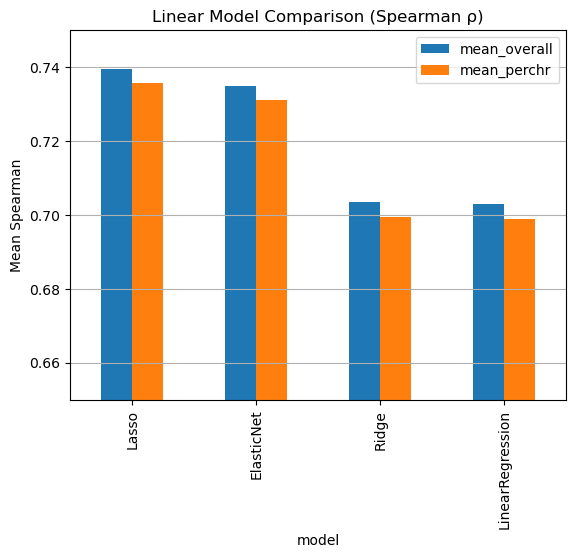

In [5]:
coef = model.named_steps["regressor"].coef_
nonzero = np.sum(coef != 0)
print(f"Non-zero features: {nonzero}/{len(coef)}")
import matplotlib.pyplot as plt

summary_df.plot(x="model", y=["mean_overall", "mean_perchr"], kind="bar")
plt.title("Linear Model Comparison (Spearman ρ)")
plt.ylabel("Mean Spearman")
plt.ylim(0.65, 0.75)
plt.grid(axis="y")
plt.show()


In [ ]:
import optuna
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings, json, os, random

warnings.filterwarnings("ignore")

# ============================================================
#                  CONFIGURATION
# ============================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

TRAIN_PATH = "../preprocessed_data/CAGE-merged/4. features selection/X1_all_rank_features_pruned_qn.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/4. features selection/X2_all_rank_features_pruned_qn.tsv"

META_COLS = [
    "gene_name", "chr", "gene_start", "gene_end",
    "TSS_start", "TSS_end", "strand", "gex", "gex_rank"
]
TARGET_COL = "gex_rank"

SAVE_DIR = "../results/linear_models/Lasso/optuna"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================================================
#                  LOAD DATA
# ============================================================
df_train = pd.read_csv(TRAIN_PATH, sep="\t")
df_val   = pd.read_csv(VAL_PATH, sep="\t")

df_all = pd.concat([df_train, df_val], ignore_index=True)
chromosomes = sorted(df_all["chr"].unique())

print(f"🧬 Total chromosomes in dataset: {chromosomes}")
print(f"Total samples: {len(df_all):,}")

feature_cols = [c for c in df_all.columns if c not in META_COLS]

# ============================================================
#                  OBJECTIVE FUNCTION
# ============================================================
def objective(trial):
    """Optuna objective: tune alpha for Lasso regression"""
    
    # 固定 chr6, chr13 + 隨機抽另外兩條作為 validation
    fixed_val_chrs = ["chr6", "chr13"]
    remaining_chrs = [c for c in chromosomes if c not in fixed_val_chrs]
    rng = random.Random(SEED + trial.number)
    random_extra = rng.sample(remaining_chrs, 2)
    val_chrs = fixed_val_chrs + random_extra
    print(f"Validation chromosomes for this trial: {val_chrs}")

    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train_fold = df_all[df_all["chr"].isin(train_chrs)].copy()
    df_val_fold   = df_all[df_all["chr"].isin(val_chrs)].copy()

    X_train, y_train = df_train_fold[feature_cols].values, df_train_fold[TARGET_COL].values
    X_val, y_val     = df_val_fold[feature_cols].values, df_val_fold[TARGET_COL].values

    # Optuna 搜尋超參數
    alpha = trial.suggest_float("alpha", 1e-6, 1.0, log=True)

    # Lasso 模型 + 標準化
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=alpha, random_state=SEED, max_iter=20000))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Spearman correlation 評估
    rho_overall = spearmanr(y_val, y_pred)[0]

    # 每個 chromosome 的平均 Spearman
    per_chr_rho = []
    for chrom, subdf in df_val_fold.assign(pred=y_pred).groupby("chr"):
        if len(subdf) > 2:
            per_chr_rho.append(spearmanr(subdf["gex_rank"], subdf["pred"])[0])
    mean_rho = np.nanmean(per_chr_rho)

    return mean_rho if not np.isnan(mean_rho) else rho_overall


# ============================================================
#                  RUN OPTIMIZATION
# ============================================================
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

# ============================================================
#                  SAVE RESULTS
# ============================================================
print("✅ Best Spearman:", study.best_value)
print("🏆 Best Parameters:")
for k, v in study.best_params.items():
    print(f"   {k}: {v}")

study.trials_dataframe().to_csv(os.path.join(SAVE_DIR, "trials_log.csv"), index=False)
with open(os.path.join(SAVE_DIR, "best_params.json"), "w") as f:
    json.dump(study.best_params, f, indent=4)

print(f"💾 Saved best params and log to {SAVE_DIR}")
import optuna
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings, json, os, random

warnings.filterwarnings("ignore")

# ============================================================
#                  CONFIGURATION
# ============================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

TRAIN_PATH = "../preprocessed_data/CAGE-merged/4. features selection/X1_all_rank_features_pruned_qn.tsv"
VAL_PATH   = "../preprocessed_data/CAGE-merged/4. features selection/X2_all_rank_features_pruned_qn.tsv"

META_COLS = [
    "gene_name", "chr", "gene_start", "gene_end",
    "TSS_start", "TSS_end", "strand", "gex", "gex_rank"
]
TARGET_COL = "gex_rank"

SAVE_DIR = "../results/lasso/optuna_fixed_chr6_chr13"
os.makedirs(SAVE_DIR, exist_ok=True)

# ============================================================
#                  LOAD DATA
# ============================================================
df_train = pd.read_csv(TRAIN_PATH, sep="\t")
df_val   = pd.read_csv(VAL_PATH, sep="\t")

df_all = pd.concat([df_train, df_val], ignore_index=True)
chromosomes = sorted(df_all["chr"].unique())

print(f"🧬 Total chromosomes in dataset: {chromosomes}")
print(f"Total samples: {len(df_all):,}")

feature_cols = [c for c in df_all.columns if c not in META_COLS]

# ============================================================
#                  OBJECTIVE FUNCTION
# ============================================================
def objective(trial):
    """Optuna objective: tune alpha for Lasso regression"""
    
    # 固定 chr6, chr13 + 隨機抽另外兩條作為 validation
    fixed_val_chrs = ["chr6", "chr13"]
    remaining_chrs = [c for c in chromosomes if c not in fixed_val_chrs]
    rng = random.Random(SEED + trial.number)
    random_extra = rng.sample(remaining_chrs, 2)
    val_chrs = fixed_val_chrs + random_extra
    print(f"Validation chromosomes for this trial: {val_chrs}")

    train_chrs = [c for c in chromosomes if c not in val_chrs]
    df_train_fold = df_all[df_all["chr"].isin(train_chrs)].copy()
    df_val_fold   = df_all[df_all["chr"].isin(val_chrs)].copy()

    X_train, y_train = df_train_fold[feature_cols].values, df_train_fold[TARGET_COL].values
    X_val, y_val     = df_val_fold[feature_cols].values, df_val_fold[TARGET_COL].values

    # Optuna 搜尋超參數
    alpha = trial.suggest_float("alpha", 1e-6, 1.0, log=True)

    # Lasso 模型 + 標準化
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=alpha, random_state=SEED, max_iter=10000))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Spearman correlation 評估
    rho_overall = spearmanr(y_val, y_pred)[0]

    # 每個 chromosome 的平均 Spearman
    per_chr_rho = []
    for chrom, subdf in df_val_fold.assign(pred=y_pred).groupby("chr"):
        if len(subdf) > 2:
            per_chr_rho.append(spearmanr(subdf["gex_rank"], subdf["pred"])[0])
    mean_rho = np.nanmean(per_chr_rho)

    return mean_rho if not np.isnan(mean_rho) else rho_overall


# ============================================================
#                  RUN OPTIMIZATION
# ============================================================
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

study.optimize(objective, n_trials=300, show_progress_bar=True)

# ============================================================
#                  SAVE RESULTS
# ============================================================
print("✅ Best Spearman:", study.best_value)
print("🏆 Best Parameters:")
for k, v in study.best_params.items():
    print(f"   {k}: {v}")

study.trials_dataframe().to_csv(os.path.join(SAVE_DIR, "trials_log.csv"), index=False)
with open(os.path.join(SAVE_DIR, "best_params.json"), "w") as f:
    json.dump(study.best_params, f, indent=4)

print(f"💾 Saved best params and log to {SAVE_DIR}")


c:\Users\wani\AppData\Local\anaconda3\envs\ML4genomics_project1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-14 12:27:00,197] A new study created in memory with name: no-name-d4ef4734-b774-456f-924a-1a7fb3993ec0


🧬 Total chromosomes in dataset: ['chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9']
Total samples: 32,568


  0%|          | 0/100 [00:00<?, ?it/s]

Validation chromosomes for this trial: ['chr6', 'chr13', 'chr14', 'chr10']


Best trial: 0. Best value: 0.724624:   1%|          | 1/100 [01:04<1:45:45, 64.10s/it]

[I 2025-10-14 12:28:04,293] Trial 0 finished with value: 0.7246238819104216 and parameters: {'alpha': 0.00017670169402947956}. Best is trial 0 with value: 0.7246238819104216.
Validation chromosomes for this trial: ['chr6', 'chr13', 'chr11', 'chr2']


Best trial: 0. Best value: 0.724624:   2%|▏         | 2/100 [01:04<43:24, 26.58s/it]  

[W 2025-10-14 12:28:04,608] Trial 1 failed with parameters: {'alpha': 0.5061576888752307} because of the following error: The value nan is not acceptable.
[W 2025-10-14 12:28:04,613] Trial 1 failed with value nan.
Validation chromosomes for this trial: ['chr6', 'chr13', 'chr3', 'chr7']


Best trial: 0. Best value: 0.724624:   3%|▎         | 3/100 [01:06<24:56, 15.43s/it]

[I 2025-10-14 12:28:06,778] Trial 2 finished with value: 0.7003585978203163 and parameters: {'alpha': 0.02465832945854911}. Best is trial 0 with value: 0.7246238819104216.
Validation chromosomes for this trial: ['chr6', 'chr13', 'chr19', 'chr3']


Best trial: 0. Best value: 0.724624:   4%|▍         | 4/100 [01:10<17:29, 10.93s/it]

[I 2025-10-14 12:28:10,808] Trial 3 finished with value: 0.717461963783772 and parameters: {'alpha': 0.003907967156822882}. Best is trial 0 with value: 0.7246238819104216.
Validation chromosomes for this trial: ['chr6', 'chr13', 'chr12', 'chr22']


Best trial: 4. Best value: 0.724939:   5%|▌         | 5/100 [03:39<1:35:54, 60.57s/it]

[I 2025-10-14 12:30:39,407] Trial 4 finished with value: 0.7249392595012281 and parameters: {'alpha': 8.63200816860254e-06}. Best is trial 4 with value: 0.7249392595012281.
Validation chromosomes for this trial: ['chr6', 'chr13', 'chr21', 'chr12']
